In [36]:
import pandas as pd
import os
import dateutil as du
import json


def to_seconds(t):
    return int(du.parser.isoparse(t).timestamp())

pwd = "/home/jfreeman/52/part3"
os.chdir(pwd)

# Set different marker styles for each application
marker_styles = ["o-", "s-", "D-", "*-", "x-", "^-", "v-"]

# Set different colors for each application
colors = {
    "parsec-blackscholes": "#CCA000",
    "parsec-canneal": "#CCCCAA",
    "parsec-dedup": "#CCACCA",
    "parsec-ferret": "#AACCCA",
    "parsec-freqmine": "#0CCA00",
    "parsec-radix": "#00CCA0",
    "parsec-vips": "#CC0A00",
}

"""
\definecolor{blackscholes}{HTML}{CCA000}
\definecolor{canneal}{HTML}{CCCCAA}
\definecolor{dedup}{HTML}{CCACCA}
\definecolor{ferret}{HTML}{AACCCA}
\definecolor{freqmine}{HTML}{0CCA00}
\definecolor{radix}{HTML}{00CCA0}
\definecolor{vips}{HTML}{CC0A00}
"""

policy = {
    "parsec-blackscholes": "[VM3; Core 1]",
    "parsec-canneal": "[VM3; Core 1-2]",
    "parsec-dedup": "[VM3; Core 4-7]",
    "parsec-ferret": "[VM3; Core 0-1]",
    "parsec-freqmine": "[VM2; Core 0]",
    "parsec-radix": "[VM2; Core 0-3]",
    "parsec-vips": "[VM2; Core 0-3]",
    "memcached": "[VM1; Core 0]"
}


application_names = ["parsec-blackscholes", "parsec-canneal", "parsec-dedup", "parsec-ferret", "parsec-freqmine", "parsec-radix", "parsec-vips"]

start_end_pairs = {}
for i in range(1, 4):
    for app_name in application_names:
        path = f"../experiments/part3/run{i}/pods.json"
        with open(path, "r") as f:
            data = json.load(f)
            # only keep the data entries that have entry["status"]["containerStatuses"][0]["state"]["terminated"]
            data = [entry["status"]["containerStatuses"][0] for entry in data["items"] if "terminated" in entry["status"]["containerStatuses"][0]["state"]]
            
            # entry is the first element in data that has entry["state"]["name"] == appname
            entry = next(entry for entry in data if entry["name"] == app_name)
            start_time = to_seconds(entry["state"]["terminated"]["startedAt"])
            end_time = to_seconds(entry["state"]["terminated"]["finishedAt"])
            start_end_pairs[(i, app_name)] = (start_time, end_time)

print(f"The following is the start and end times for each application of each run: \n{start_end_pairs}")           
            
# calculate the average and std makespan for each application
makespans = {}
for app_name in application_names:
    makespans[app_name] = []
    for i in range(1, 4):
        start_time, end_time = start_end_pairs[(i, app_name)]
        makespan = end_time - start_time
        makespans[app_name].append(makespan)

    makespans[app_name] = (sum(makespans[app_name]) / 3, pd.Series(makespans[app_name]).std())

# calculate average and std makespan for total (earliest start time to latest end time)
makespans["total"] = []
for i in range(1, 4):
    start_time, end_time = start_end_pairs[(i, "parsec-blackscholes")]
    for app_name in application_names:
        start_time = min(start_time, start_end_pairs[(i, app_name)][0])
        end_time = max(end_time, start_end_pairs[(i, app_name)][1])
    makespan = end_time - start_time
    makespans["total"].append(makespan)

makespans["total"] = (sum(makespans["total"]) / 3, pd.Series(makespans["total"]).std())
print(f"The following is the average and std makespan for each application: \n{makespans}")

# all on one thread.
tt_path = f"../experiments/part3/mcperf_msmts.txt"
marker_styles = {app: style for app, style in zip(application_names, marker_styles)}

df = pd.read_csv(tt_path, delim_whitespace=True)
print(f"The following is the data frame for {tt_path}:")
df




The following is the start and end times for each application of each run: 
{(1, 'parsec-blackscholes'): (1715079005, 1715079006), (1, 'parsec-canneal'): (1715078983, 1715078994), (1, 'parsec-dedup'): (1715078984, 1715078998), (1, 'parsec-ferret'): (1715078981, 1715078988), (1, 'parsec-freqmine'): (1715078982, 1715078988), (1, 'parsec-radix'): (1715078978, 1715078989), (1, 'parsec-vips'): (1715078979, 1715079015), (2, 'parsec-blackscholes'): (1715079065, 1715079067), (2, 'parsec-canneal'): (1715079029, 1715079057), (2, 'parsec-dedup'): (1715079028, 1715079059), (2, 'parsec-ferret'): (1715079030, 1715079042), (2, 'parsec-freqmine'): (1715079031, 1715079040), (2, 'parsec-radix'): (1715079026, 1715079036), (2, 'parsec-vips'): (1715079026, 1715079063), (3, 'parsec-blackscholes'): (1715079104, 1715079105), (3, 'parsec-canneal'): (1715079078, 1715079094), (3, 'parsec-dedup'): (1715079080, 1715079096), (3, 'parsec-ferret'): (1715079079, 1715079087), (3, 'parsec-freqmine'): (1715079077, 171507

,#type,avg,std,min,p5,p10,p50,p67,p75,p80,p85,p90,p95,p99,p999,p9999,QPS,target,ts_start,ts_end
0,read,307.8,195.5,160.7,204.2,216.8,288.1,327.3,349.5,366.9,387.6,413.8,453.1,539.2,1470.5,8236.2,29956.3,30000,1715078144427,1715078154619
1,read,309.1,177.2,160.7,205.7,218.2,289.2,328.9,351.4,368.5,389.3,415.8,456.9,545.1,1432.0,8143.6,29925.2,30005,1715078156127,1715078166267
2,read,313.2,212.5,148.8,206.7,219.8,292.5,332.8,355.6,372.2,393.3,420.2,460.4,544.3,1617.6,9261.6,29989.2,30010,1715078167773,1715078177885
3,read,313.7,221.5,148.8,207.5,220.5,293.7,334.1,356.9,372.8,393.7,419.9,458.5,540.0,1509.1,11824.9,30060.6,30015,1715078179393,1715078189508
4,read,313.5,219.9,160.7,208.2,221.1,291.9,332.1,355.8,372.9,394.3,421.3,460.9,548.2,1343.8,11069.8,30016.5,30020,1715078191015,1715078201128
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81,read,310.8,249.6,148.8,204.2,217.5,286.2,325.4,350.5,369.9,393.4,423.6,467.3,572.9,1244.9,15233.9,30458.3,30405,1715079085750,1715079095859
82,read,313.5,300.5,148.8,205.5,219.4,289.7,327.5,350.2,368.2,389.7,417.0,457.9,544.0,1776.8,16516.0,30412.5,30410,1715079097363,1715079107473
83,read,311.7,256.3,160.7,206.2,219.6,289.0,326.3,348.8,366.3,387.0,413.1,452.8,542.3,1869.9,12705.0,30424.0,30415,1715079108980,1715079119090
84,read,311.8,307.5,160.7,205.5,219.1,287.9,324.8,347.0,365.0,385.7,411.7,451.8,536.8,2211.2,16540.1,30402.1,30420,1715079120598,1715079130706


{'parsec-blackscholes': 'o-', 'parsec-canneal': 's-', 'parsec-dedup': 'D-', 'parsec-ferret': '*-', 'parsec-freqmine': 'x-', 'parsec-radix': '^-', 'parsec-vips': 'v-'}
Earliest start: 1715078978, Latest end: 1715079015 for run 1
Earliest start: 1715079026, Latest end: 1715079067 for run 2
Earliest start: 1715079075, Latest end: 1715079112 for run 3


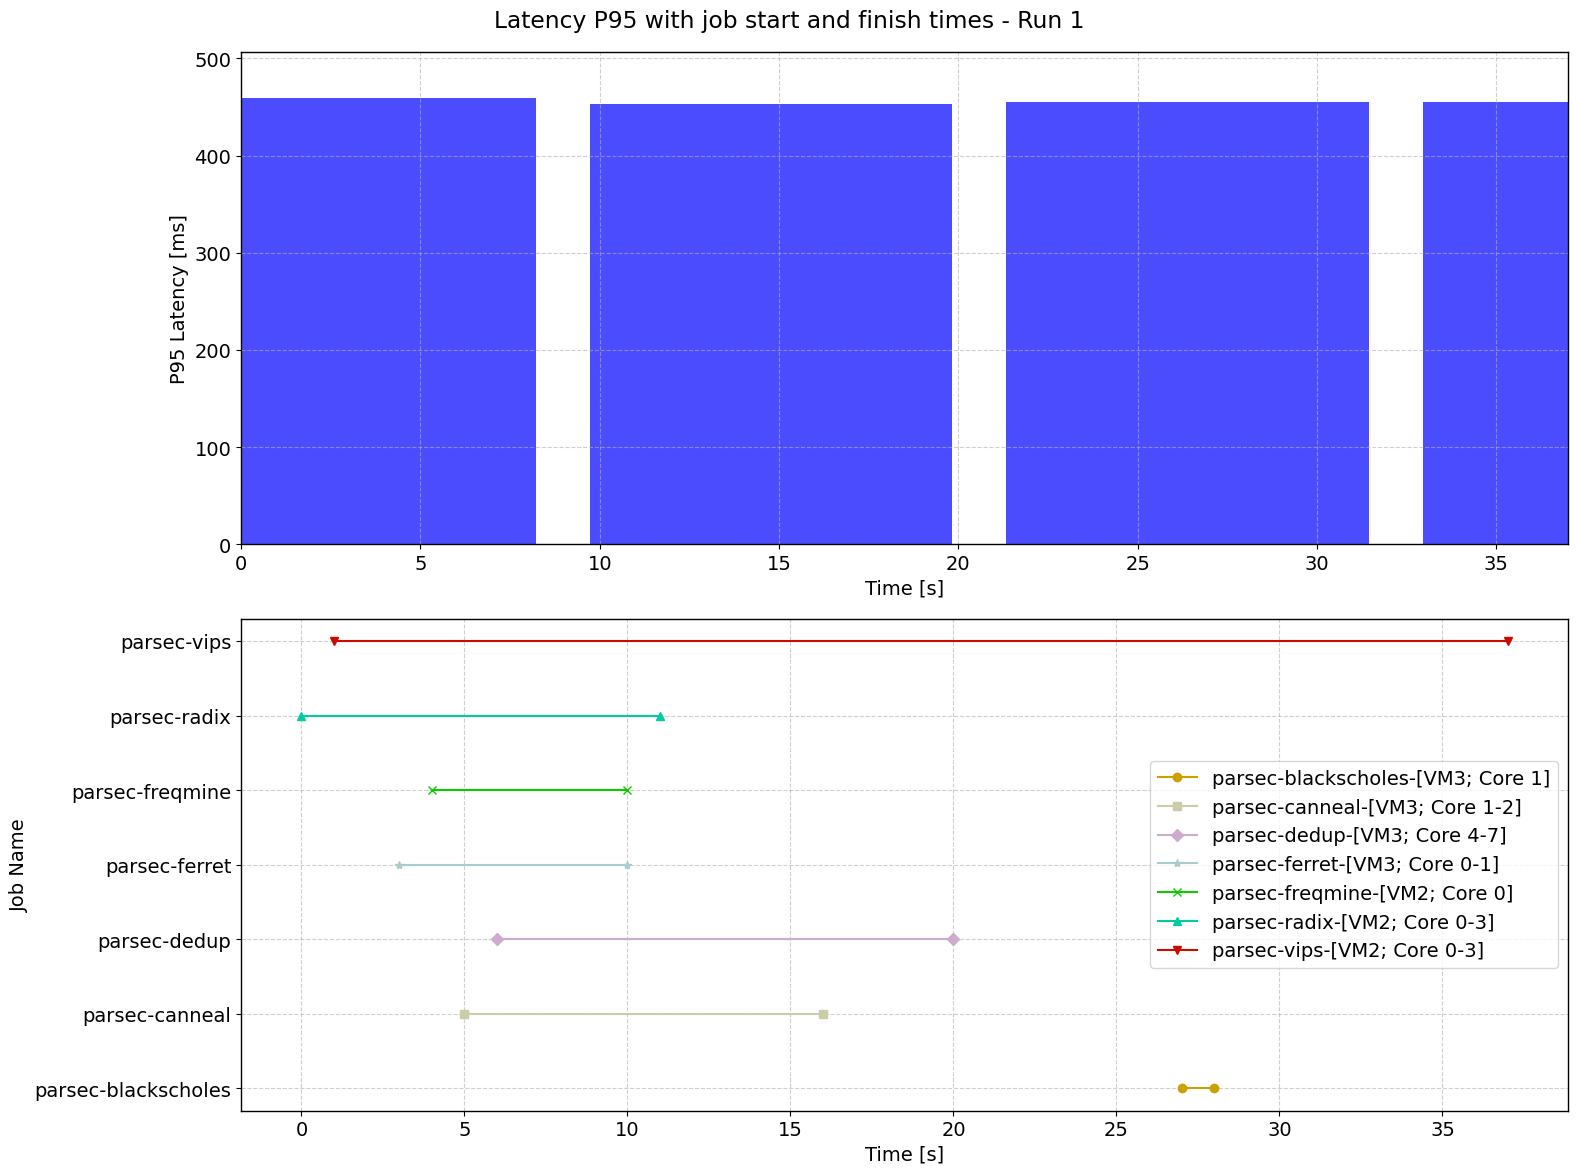

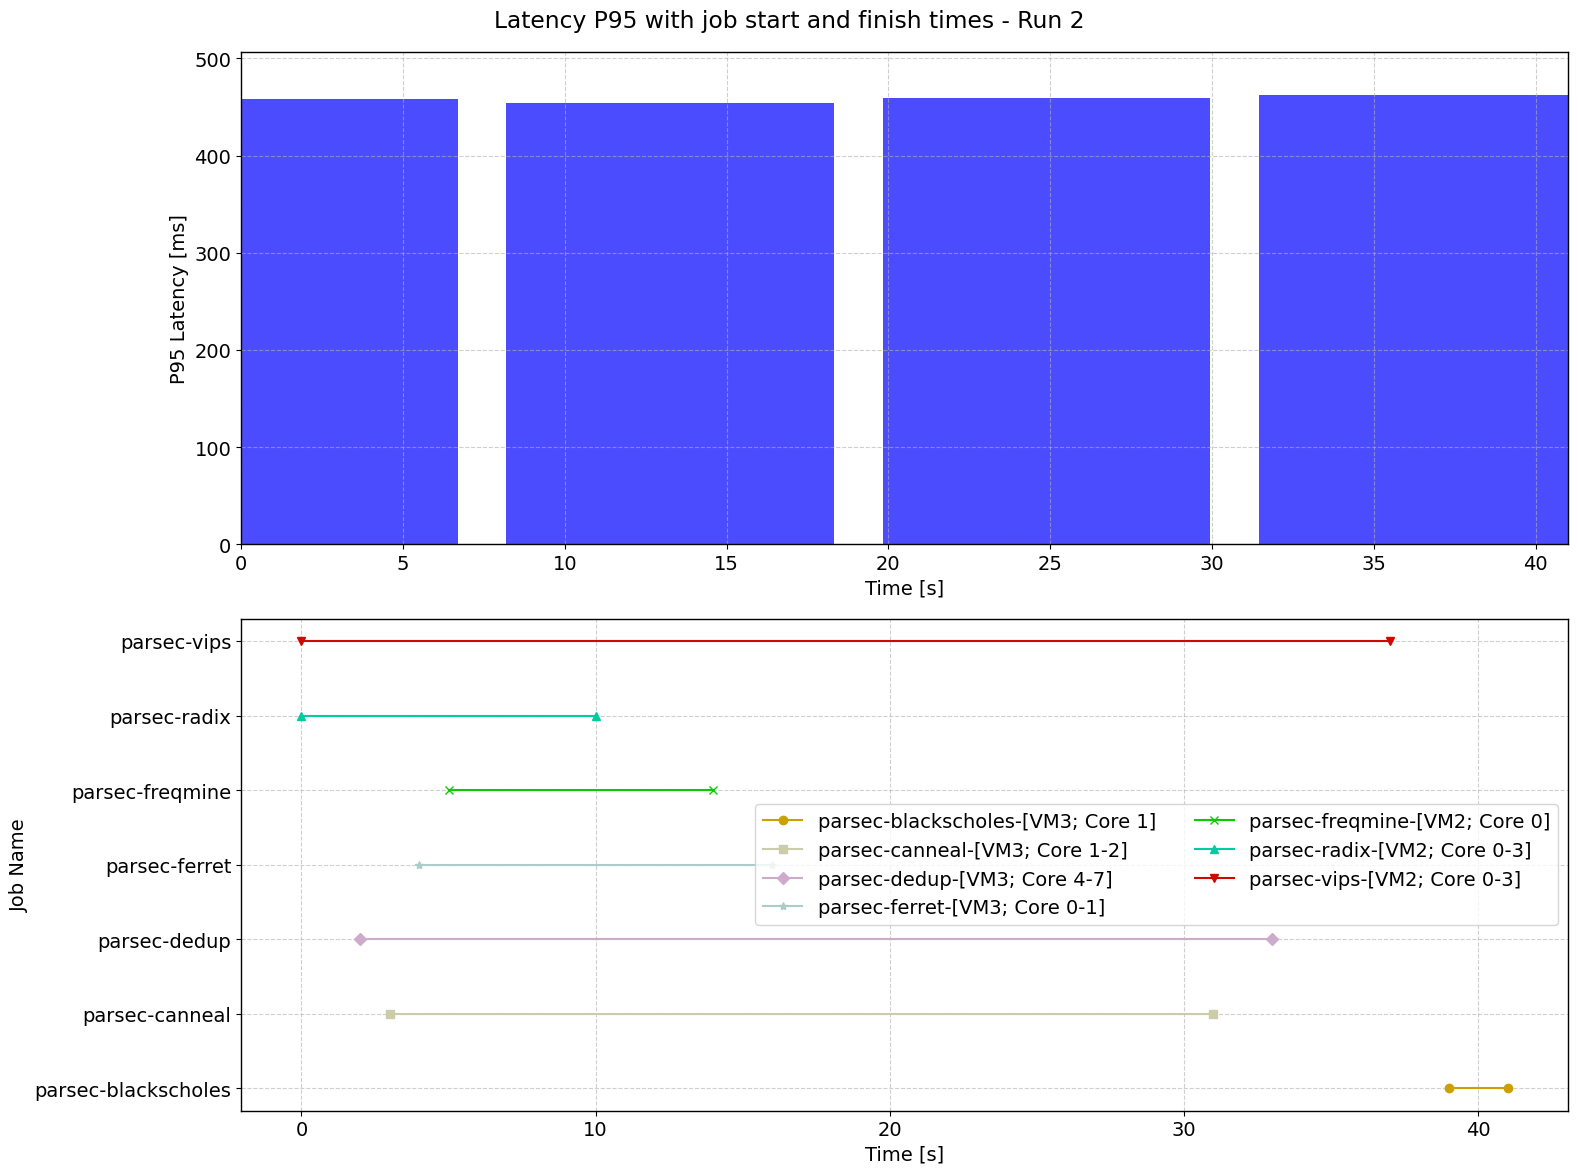

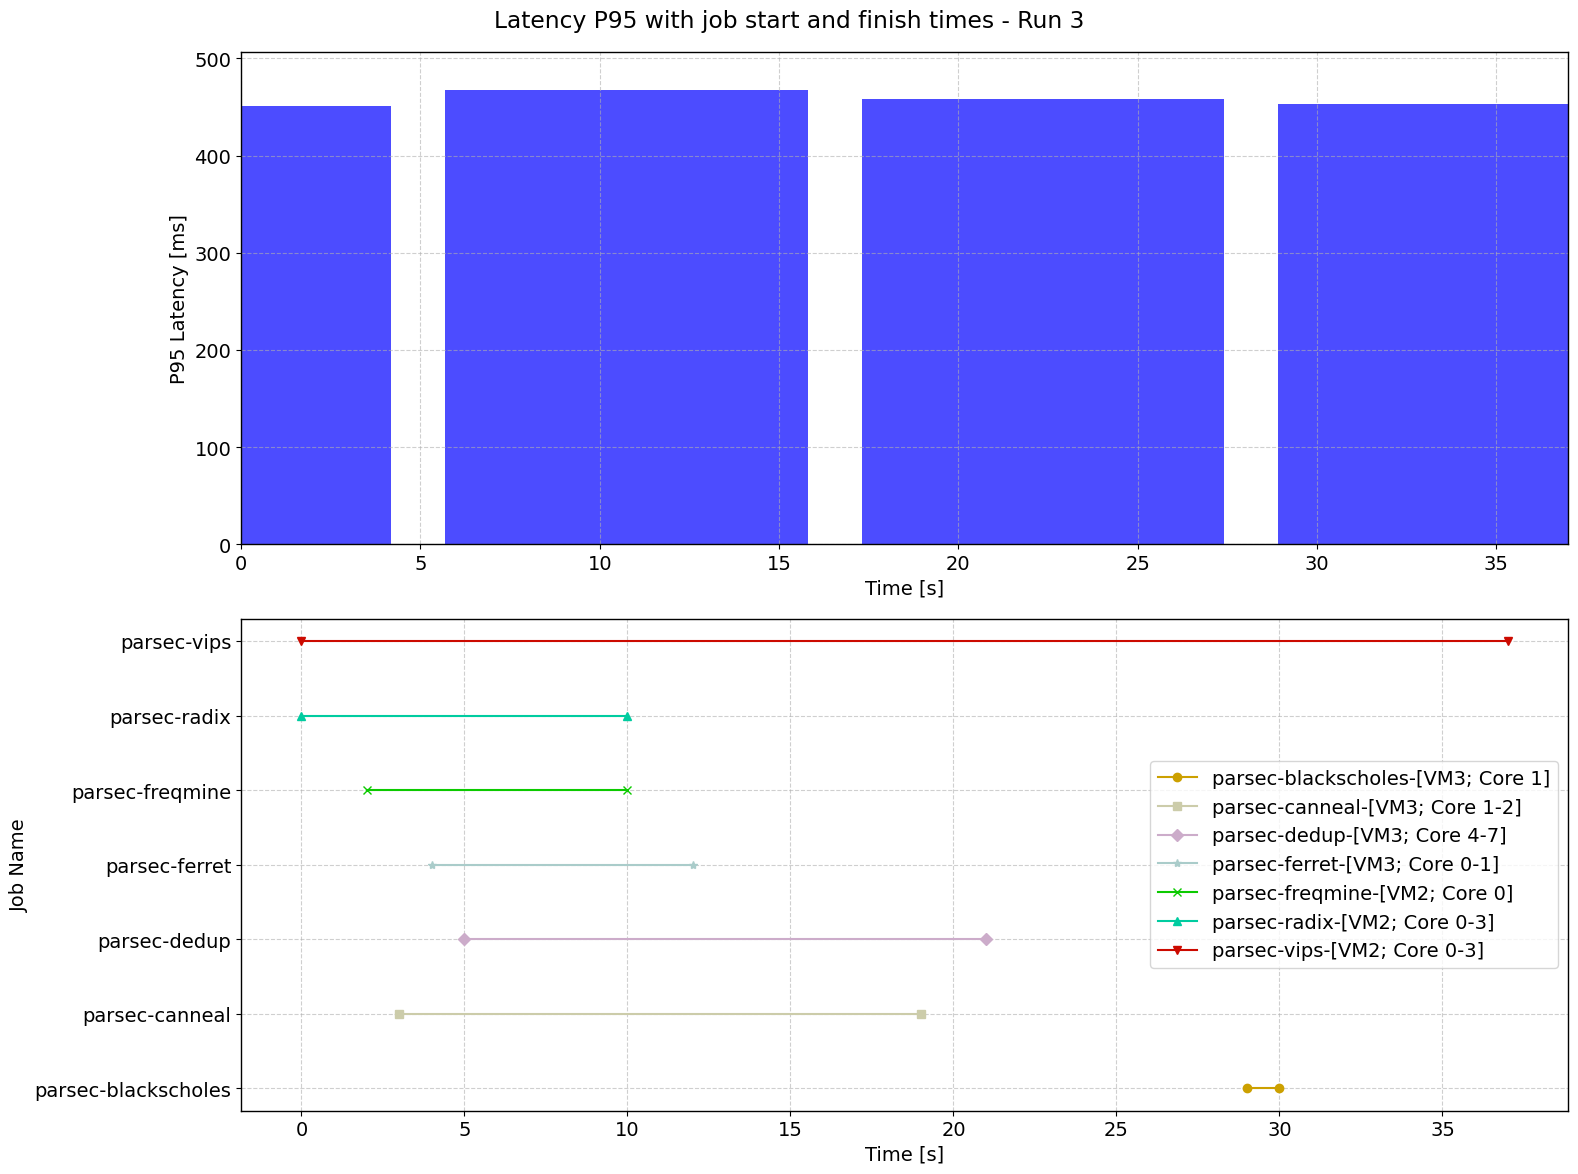

In [53]:
import matplotlib.pyplot as plt
import numpy as np
# make into a dictionary

print(marker_styles)
def create_plots(df, start_end_pairs, marker_styles, colors, policy):
    runs = [1, 2, 3]
    # set font size
    plt.rcParams.update({'font.size': 14})
    for run in runs:
        start_end_run = {k[1]: v for k, v in start_end_pairs.items() if k[0] == run}
        earliest_start = np.min([v[0] for v in start_end_run.values()])
        latest_end = np.max([v[1] for v in start_end_run.values()])
        print(f"Earliest start: {earliest_start}, Latest end: {latest_end} for run {run}")

        fig, axs = plt.subplots(2, figsize=(16,12))
        fig.suptitle(f'Latency P95 with job start and finish times - Run {run}')

        for app, times in start_end_run.items():
            start = (times[0] - earliest_start)
            end = (times[1] - earliest_start)

            y = app
            axs[1].plot([start, end], [y, y], marker_styles[app], color=colors[app], label=f"{app}-{policy[app]}")

        axs[1].set_xlabel('Time [s]')
        axs[1].set_ylabel('Job Name')

        axs[1].set_yticks(range(len(start_end_run.keys())))
        axs[1].set_yticklabels(start_end_run.keys())

        axs[1].grid(True, linestyle='--', alpha=0.6)
        axs[1].legend(loc='best')

        latencies = df['p95']
        start_times = (df['ts_start'] - earliest_start*1000) / 1000
        widths = (df['ts_end'] - df['ts_start']) / 1000

        axs[0].bar(start_times, latencies, width=widths, color='blue', alpha=0.7)
        axs[0].set_xlabel('Time [s]')
        axs[0].set_ylabel('P95 Latency [ms]')
        
        axs[0].grid(True, linestyle='--', alpha=0.6)
        axs[0].set_xlim([0, (latest_end - earliest_start)])

        for ax in axs:
            for spine in ax.spines.values():
                spine.set_color('black')
                spine.set_linewidth(1)
        # make sure that the legend is not covering a line. If the plot is the second plot, move the legend down a bit
        # loc can be one of the following: 'upper center', 'upper right', 'upper left', 'lower left', 'lower right', 'lower center', 'center right', 'center left', 'center', 'best'
        # or a tuple of the form (x, y) where x and y are floats between 0 and 1
        # once best is chosen, it can be  shifted via bbox_to_anchor

        if run == 2:
            axs[1].legend(loc='center right', bbox_to_anchor=(1.2, 0.5))
        else:
            axs[1].legend(loc='best')


        plt.tight_layout()
        #export as a pdf
        plt.savefig(f'run{run}_latency_p95.pdf')

create_plots(df, start_end_pairs, marker_styles, colors, policy)